# Zero Inflated Poisson (ZIP) Regression
> "How to effectively model count data with sparse predictors"
- toc: false
- branch: master
- badges: true
- comments: true
- image: images/zip.png
- hide: false
- search_exclude: false

### Motivation

The Poisson distribution can be derived as a limiting form of the binomial distribution if you consider the distribution of the number of successes in a very large number of Bernoulli trials with a small probability of success in each trial. Thus, the Poisson distribution provides an approximation to the binomial for the analysis of rare events.

The classic text on probability theory by Feller (1957) includes a number of examples of observations fitting the Poisson distribution, including data on the number of flying-bomb hits in the south of London during World War II. The city was divided into 576 small areas of one-quarter square kilometers each, and the number of areas hit exactly k times was counted. There were a total of 537 hits, so the average number of hits per area was 0.9323.

In the flying-bomb example, we can think of each day as one of a large number of trials where each specific area has only a small probability of being hit. Assuming independence across days would lead to a binomial distribution which is well approximated by the Poisson. Alternatively, if we consider the Poisson distribution in terms of a stochastic process, the porbability of at least one occurence of the event in a given time interval is propotional to the length of the interval. 

Unlike this traditional Poisson distribution, many real world phenomena produce counts that are almost always zero. For example, the number of sales per item in a store. Such data are hard to deal with using traditional models for counts data such as the Poisson, the Binomial or the Negative Binomial regression models. This is because such data sets contain more number of zero valued counts than what one would expect to observe using the traditional model’s probability distribution.

To demonstrate, recall the PMF for a Poisson distribution $$ P(y=k) = \frac{e^{-\lambda}*\lambda^k}{k!}  $$
Where $\lambda_i = e^{x_i\beta}$- here $\beta$ is the vector of regression coefficients

If we assume that our events obey a Poisson(5) process, you would expect to see zero counts no more than 0.67% of the time:

<AxesSubplot:ylabel='Count'>

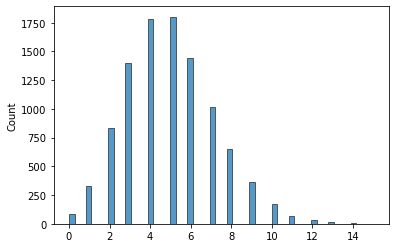

In [9]:
s = np.random.poisson(5, 10000)
sns.histplot(s)

As a result, if you use a standard Poisson or Binomial or NB regression model on such data sets, it can fit badly and will generate poor quality predictions, no matter how much you tweak its parameters

<br>

### The ZIP Model

Fortunately, the ZIP model provides us with a modification of the standard counts model such as Poisson or Negative Binomial to account for the presence of the extra zeroes. Another technique, called the Hurdle Model, has also been designed to deal with the excess zeroes, but here we will focus on ZIP.

The intuition behind the ZIP model is that there is a second underlying process that is determining whether a count is zero or non-zero. Once a count is determined to be non-zero, the regular Poisson process takes over to determine its actual non-zero value based on the Poisson process’s PMF. The PMF of the ZIP model is as follows:
$$
P(y_i)\left\{\begin{matrix}
y_i = 1,2,3... & \phi_i + (1-\phi_i)*e^{-\lambda}\\ 
y_i = 0 & (1-\phi_i)\frac{e^{-\lambda}*\lambda^k}{k!}
\end{matrix}\right.
$$

The main difference between the ZIP model and the above mentioned Poisson process if the addition of the $\phi$ parameter, which is a measure of the proportion of excess zeroes corresponding to the ith row in the dataset. Described differently, it can be considered a weight or penalty that increased the tendancy of the model to add structural zeroes to its posterior modeling of the distribution. Thus, a $\phi$ value of zero results in the ZIP model reducing to a standard Poisson process and PMF.

A crude way to calculate $\phi$ would be to set it as the number of zero valued samples divided by the total number of samples. A better way to estimate $\phi$ would be to estimate it as a function of our regressor variables/features. This is done by transforming the y variable (a continuous count) into a binary 0 or 1 variable. We then fit a logistic regression model on the binary y to produce fitted probabilities of an outcome whith or without an event. This vector of probabilities of a non-zero event is set as our $\phi$ vector. We can then use Maximum Likelihood Estimation (MLE) to train the ZIP model.

### Demo

Thankfully, there are many python packages that automate the procedure of estimating $\phi$ and using the estimated $\phi$ to train the ZIP model using the MLE technique on your data set. Here we will use statsmodels, but there are other python implementations such as pymc3. Along with the statsmodels implementation, we will use daily retail sales data as our features.

In [20]:
import pickle
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [13]:
with open(weekly_sales, 'rb') as f:
    frames = pickle.load(f)

In [14]:
w1_df = pd.concat(frames)
df = w1_df.sample(n=100000)

Below we can see that most of our entries for y are zero, but we also have considerable sales (count) data.

<AxesSubplot:ylabel='Density'>

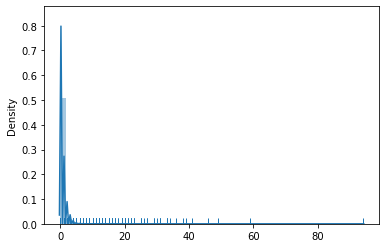

In [36]:
sns.distplot(y, rug=True)

In [19]:
X = df.drop(['part', 'sales_quantity'], axis=1)
y = df['sales_quantity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train,
                                              exog=X_train,
                                              exog_infl=X_train,
                                              inflation='logit').fit()

         Current function value: 7.028915
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3


In [23]:
zip_predictions = zip_training_results.predict(X_test
                                               ,exog_infl=X_test)

In [27]:
print("Mean Absolute Error (MAE) for ZIP predictions: {0}".format(mean_absolute_error(y_test, zip_predictions)))

Mean Absolute Error (MAE) for ZIP predictions: 0.29544


In [29]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_predictions = xgb_reg.predict(X_test)

In [30]:
print("Mean Absolute Error (MAE) for XGBoost predictions: {0}".format(mean_absolute_error(y_test, xgb_predictions)))

Mean Absolute Error (MAE) for XGBoost predictions: 0.35163331031799316


Thus the ZIP model performs significantly better than a gradient boosting algorithm for our case. 